In [340]:
import random
import sys
from typing import Callable, List
import time
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [540]:
class LogLinearModel:
    def __init__(
        self,
        feature_function: Callable,
        learning_rate: float,
        iterations: int,
        loss: Callable,
        gradient_loss: Callable,
        verbose: bool,
    ):
        """
        Parameters
        ---
        feature_function : Callable
            Feature function mapping from X x Y -> R^m
        learning_rate : float
            Learning rate parameter eta for gradient descent
        iterations : int
            Number of iterations to run gradient descent for during `fit`
        loss : Callable
            Loss function to be used by this LogLinearModel instance as
            a function of the parameters and the data X and y
        gradient_loss : Callable
            Closed form gradient of the `loss` function used for gradient descent as
            a function of the parameters and the data X and y
        verbose : bool
            Verbosity level of the class. If verbose == True,
            the class will print updates about the gradient
            descent steps during `fit`

        """
        self.feature_function=feature_function
        self.learning_rate=learning_rate
        self.iterations=iterations
        self.loss=loss
        self.gradient_loss=gradient_loss
        self.verbose=verbose
        
        self.coef_ = None
        self.change=None
        

    def gradient_descent(self, X: np.ndarray, y: np.ndarray):
        """Performs one gradient descent step, and update parameters inplace.

        Parameters
        ---
        X : np.ndarray
            Data matrix
        y : np.ndarray
            Binary target values

        Returns
        ---
        None

        """
        
        self.change= self.learning_rate*self.gradient_loss(self.coef_,self.feature_function,X,y)
        self.coef_-=self.change
       
        
    def fit(self, X: np.ndarray, y: np.ndarray):
        """Fits LogLinearModel class using gradient descent.

        Parameters
        ---
        X : np.ndarray
            Input data matrix
        y : np.ndarray
            Binary target values

        Returns
        ---
        None

        """
        self.coef_=np.zeros_like(self.feature_function(X[0],y[0]))
        for i in range(self.iterations):
            self.gradient_descent(X,y)
            if self.verbose==True:    
                print("Iteration ",i +1 ,"/",self.iterations, " --------- Loss : ",self.loss(self.coef_,self.feature_function,X,y) ," --------- Largest absolute change: ", np.max(abs(self.change)) )
            

        

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predicts binary target labels for input data `X`.

        Parameters
        ---
        X : np.ndarray
            Input data matrix

        Returns
        ---
        np.ndarray
            Predicted binary target labels

        """
        n=len(X)
        predictions=[]
        f=self.feature_function
        for i in range(n):
            if  np.exp(np.dot(self.coef_,f(X[i],1)) )/(np.exp(np.dot(self.coef_,f(X[i],0)) ) + np.exp(np.dot(self.coef_,f(X[i],1)))) > 1/2:
                predictions.append(1)
            else:
                predictions.append(0)
        return np.array(predictions)
    def score(self, X: np.ndarray, y: np.ndarray):
        pred = self.predict(X)
        return len([pred[i] for i in range(0, len(pred)) if pred[i] == y[i]]) / len(pred)
            

The negative likelihood is given by : LL(\theta) = $$-\sum_i{ \theta . f(x_i,y_i) - log(e^{\theta . f(x_i,0)} + e^{\theta . f(x_i,1)}) }$$ 
We can then easily deduce the gradient : $$ \nabla LL(\theta) = \sum_i{\frac{e^{\theta . f(x_i,0)}f(x_i,0) + e^{\theta . f(x_i,1)} f(x_i,1)}{e^{\theta . f(x_i,0)} + e^{\theta . f(x_i,1)}}}-\sum_i{f(x_i,y_i)}$$
f is the feature function and the expression used here for f is given by:
$$f(x,y)=x \mathbb{1}_{ \{y =1 \}}$$

In [541]:
def feature_function(x,y):
    if y==0:
        return np.zeros_like(x)
    else:
        return x


def negative_log_likelihood(theta,f,X,y):
    n=len(y)
    LL=0
    for i in range(n):
        LL-=np.dot(theta,f(X[i],y[i])) - np.log( np.exp(np.dot(theta,f(X[i],0)) ) + np.exp(np.dot(theta,f(X[i],1))))
    return LL

def gradient_negative_log_likelihood(theta,f,X,y):
    n=len(y)
    GLL=np.zeros_like(theta)
    for i in range(n):
        GLL+= - f(X[i],y[i]) + (np.exp(np.dot(theta,f(X[i],0)) )*f(X[i],0) + np.exp(np.dot(theta,f(X[i],1)) )*f(X[i],1))/(np.exp(np.dot(theta,f(X[i],0)) ) + np.exp(np.dot(theta,f(X[i],1)) ))
    return GLL

In [542]:
# Set seeds to ensure reproducibility
np.random.seed(42)
random.seed(42)

In [558]:
print(np.dot([0,0,0],[4,45,5]))

0


In [543]:
def model_evaluation(model,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fitting time
    start_time =time.time()
    model.fit(X_train,y_train)
    fit_duration=time.time()-start_time
    
    # Prediction time
    start_time =time.time()
    predictions=model.predict(X_test)
    predictions_duration=time.time()-start_time
    
    # In sample accuracy
    train_score=model.score(X_train,y_train)
    
    # Out sample accuracy
    test_score=model.score(X_test,y_test)
    # coef values
    coef_values=np.reshape(model.coef_,(len(X_test[0]),))
    
    return fit_duration,predictions_duration,train_score,test_score,coef_values
    

In [615]:
def models_comparison(X,y):
    ME_lr=model_evaluation(lr,X,y)
    ME_llm=model_evaluation(llm,X,y)
    print('training time : ------------ lr : ', ME_lr[0], ' ------------- llm : ',ME_llm[0])
    print('testing time : ------------ lr : ', ME_lr[1], ' ------------- llm : ',ME_llm[1])
    print('training score : ------------ lr : ', ME_lr[2], ' ------------- llm : ',ME_llm[2])
    print('testing score : ------------ lr : ', ME_lr[3], ' ------------- llm : ',ME_llm[3])
    fig=plt.figure(figsize=(20,10))
    
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax1 = fig.add_subplot(3, 2, 1)
    ax1.bar(['lr fit'],[ME_lr[0]])
    ax1.bar(['llm fit'],[ME_llm[0]])
    ax1.set_title("Training  time")
    
    ax2 = fig.add_subplot(3, 2, 2)
    ax2.bar(['lr prediction'],[ME_llm[1]])
    ax2.bar(['llm prediction'],[ME_llm[1]])
    ax2.set_title("Prediction time")
    
    ax3 = fig.add_subplot(3, 2, 3)
    ax3.bar(['lr '],[ME_lr[2]])
    ax3.bar(['llm'],[ME_llm[2]])
    ax3.set_title("Training  score")
    
    ax4 = fig.add_subplot(3, 2, 4)
    ax4.bar(['lr '],[ME_lr[3]])
    ax4.bar(['llm'],[ME_llm[3]])
    ax4.set_title("Test  score")
    
    fig=plt.figure(figsize=(20,10))
    ax5 = fig.add_subplot(1, 2, 1)
    lr_n=len(ME_lr[4])
    ax5.scatter(np.linspace(1,lr_n,lr_n),ME_lr[4],label='lr')
    llm_n=len(ME_llm[4])
    ax5.scatter(np.linspace(1,llm_n,llm_n),ME_llm[4],label='llm')
    ax5.set_title(" coefficients comparison")
    ax5.legend()
    
    ax6 = fig.add_subplot(1, 2, 2)
    label_ = 'Mean squared error ' + str(((ME_lr[4] - ME_llm[4])**2).mean(axis=0))
    ax6.scatter(ME_lr[4],ME_llm[4],label=label_)
    ax6.set_title(" llm = f(lr)")
    ax6.legend()
    
    plt.show()

In [616]:
learning_rate=0.004
lr = LogisticRegression()

llm = LogLinearModel(
    feature_function=feature_function,  
    learning_rate=learning_rate, 
                                  
    iterations=100,
    loss=negative_log_likelihood,  
    gradient_loss=gradient_negative_log_likelihood,  
    verbose=False
)


In [617]:
# First dataset
# Fit both `lr` and your `llm` on this dataset and compare
# the aspects described in the assignment PDF
X, y = make_classification(
    n_samples=100, random_state=42, n_informative=20, n_features=20, n_redundant=0
)


training time : ------------ lr :  0.010971784591674805  ------------- llm :  0.37174201011657715
testing time : ------------ lr :  0.0  ------------- llm :  0.0
training score : ------------ lr :  0.925  ------------- llm :  0.9125
testing score : ------------ lr :  0.6  ------------- llm :  0.55


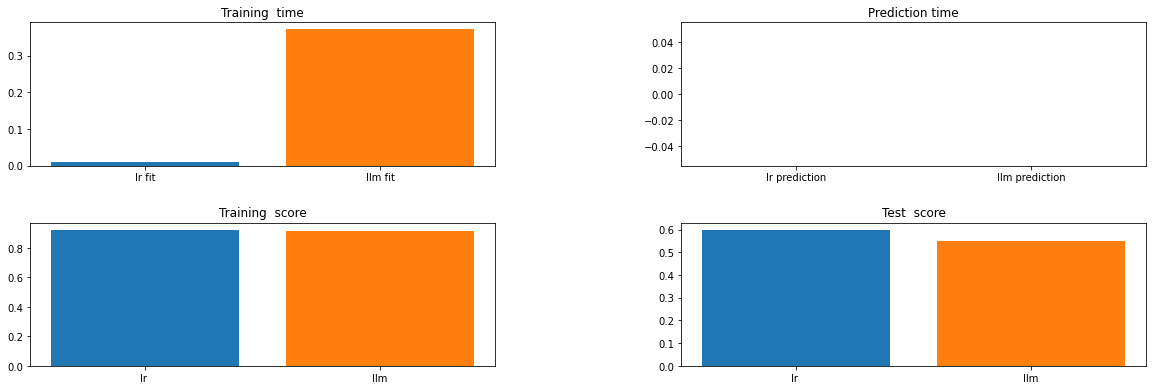

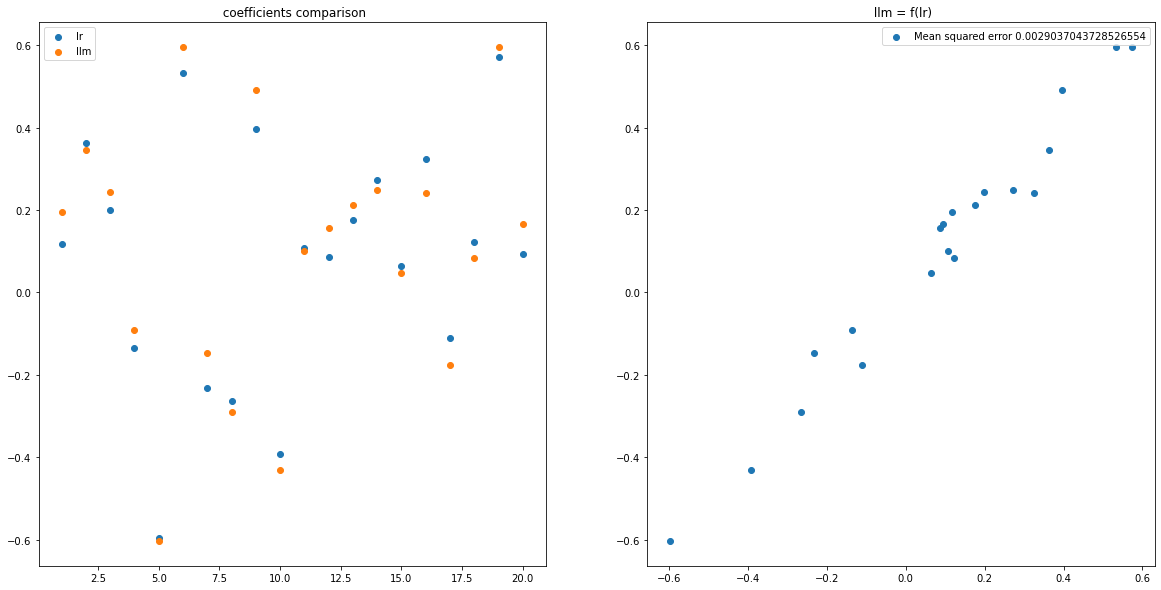

In [618]:
models_comparison(X,y)

In [619]:
learning_rate=1e-4
lr = LogisticRegression()

llm = LogLinearModel(
    feature_function=feature_function,  # TODO
    learning_rate=learning_rate,  # Make sure that the model converges
                                  # with your chosen learning rate
    iterations=100,
    loss=negative_log_likelihood,  # TODO
    gradient_loss=gradient_negative_log_likelihood,  # TODO
    verbose=False
)


In [620]:
# Second dataset
# Fit both `lr` and your `llm` on this dataset and compare
# the aspects described in the assignment PDF
X, y = make_classification(
    n_samples=1000,
    random_state=42,
    n_informative=20,
    n_redundant=10,
    n_features=35,
    n_repeated=5,
)


training time : ------------ lr :  0.025933504104614258  ------------- llm :  3.7640633583068848
testing time : ------------ lr :  0.0  ------------- llm :  0.0029921531677246094
training score : ------------ lr :  0.8225  ------------- llm :  0.82625
testing score : ------------ lr :  0.805  ------------- llm :  0.81


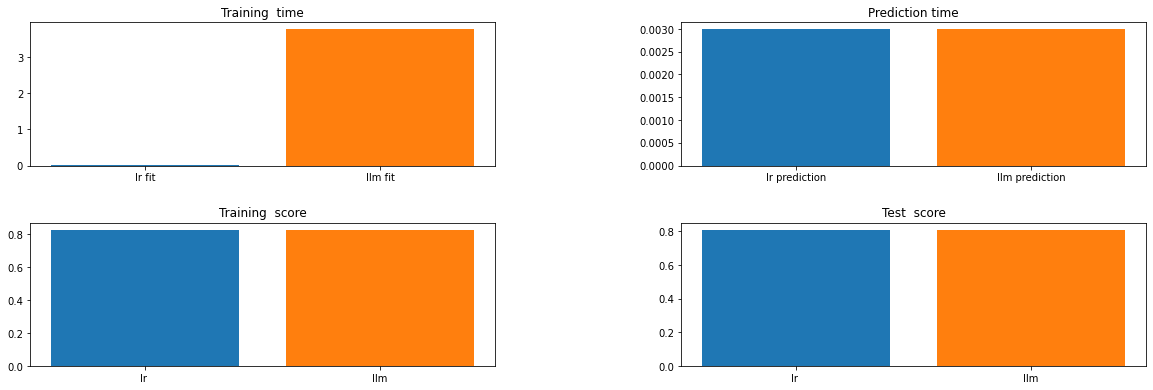

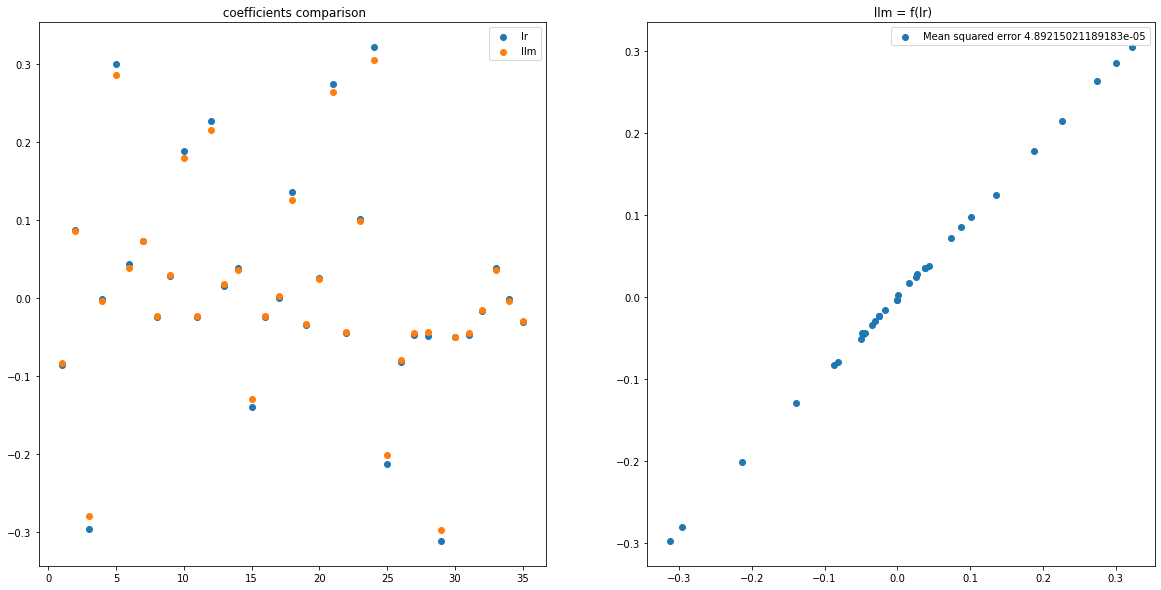

In [621]:
models_comparison(X,y)

In [622]:
learning_rate=1e-4
lr = LogisticRegression()

llm = LogLinearModel(
    feature_function=feature_function,  # TODO
    learning_rate=learning_rate,  # Make sure that the model converges
                                  # with your chosen learning rate
    iterations=100,
    loss=negative_log_likelihood,  # TODO
    gradient_loss=gradient_negative_log_likelihood,  # TODO
    verbose=False
)


In [623]:
# Third dataset
# Fit both `lr` and your `llm` on this dataset and compare
# the aspects described in the assignment PDF
X, y = make_classification(
    n_samples=10000, random_state=42, n_informative=2, n_repeated=5
)


training time : ------------ lr :  0.01595616340637207  ------------- llm :  35.155027627944946
testing time : ------------ lr :  0.0  ------------- llm :  0.039891958236694336
training score : ------------ lr :  0.89125  ------------- llm :  0.8905
testing score : ------------ lr :  0.8895  ------------- llm :  0.8915


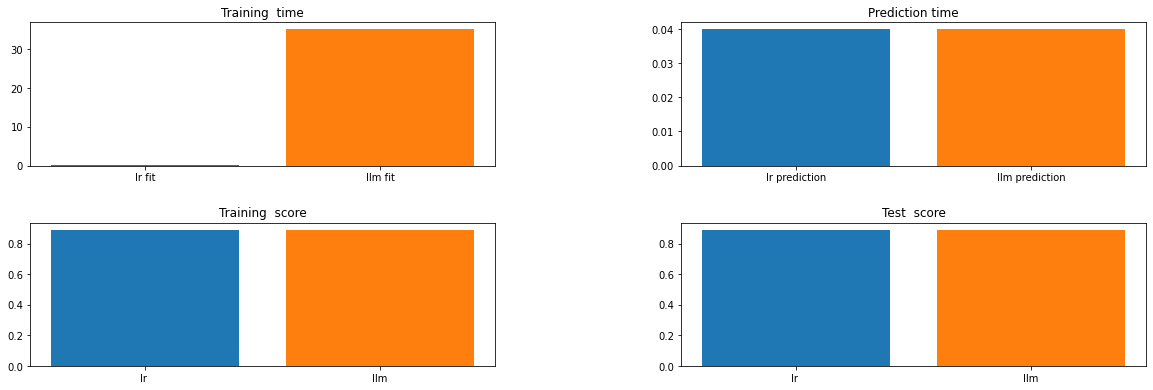

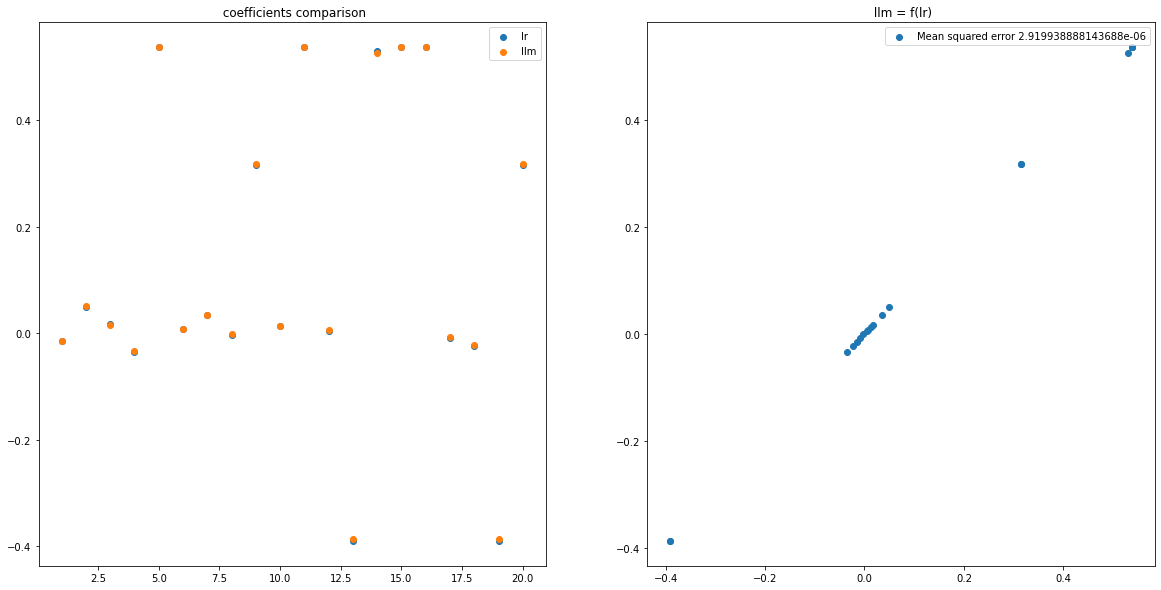

In [624]:
models_comparison(X,y)

# Comments

We can noticed that The lr and llm algorithms have almost similar prediction time (even if lr remains faster). However the lr algorithm is much more faster than llm during the training process. llm speed depends heavily on the size of the dataset (40 times slower for the last dataset). It is slower and the speed get worse with big datasets. Even if llrm is slower the more data is added the more precise it becomes(The test score reach and get higher than lr test score). lr tends to overfit but llm does not. 
With the feature function we can create diverse models which precision increases with the size of the dataset (Deep learning!).  